<span style="font-size:20pt;color:blue">Add title here</span>

This is a sample file of interactive stopped-flow data analysis. You do <b>NOT</b> need to understand python language to use this program. By replacing file names and options with your own, you can easily produce figures and interactively adjust plotting optinos. 

It is strongly recommended to keep this file for reference, and make edits on a duplication of this file. 

# import libraries and define functions
<span style="color:red">Press Ctrl+Enter to run sections</span>

In [12]:
import mpld3
mpld3.enable_notebook()
%matplotlib notebook
from sf_utils import *

# compare multiple inputs on selected lines
In many cases, the same trace may be repeated for several times. This 

<IPython.core.display.Javascript object>


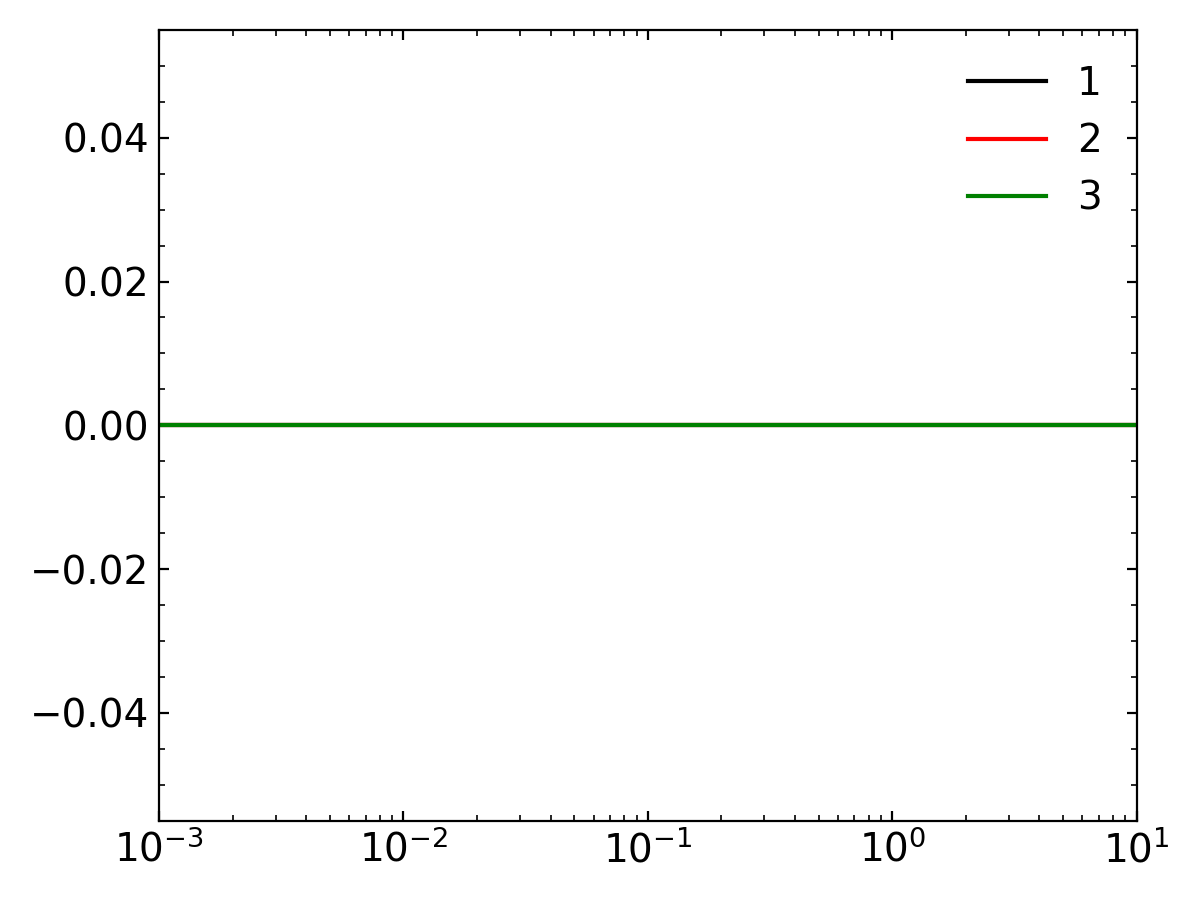

In [13]:
rcParams['figure.figsize'] = [6, 4.5]
csvfiles = [
    'average-sample-10s-1.csv',
    'average-sample-10s-2.csv',
    'average-sample-10s-3.csv',
]


sfData = SFData.quickload_csv(csvfiles)

sfData.plot_selected_kinetics()
display(widgets.HBox([sfData.add_logx_button(), sfData.plot_scan_wavelength_button()]))
sfData.plot_interactive_buttons_for_kinetics()

# save averaged files

In [14]:
csvfiles = [
    'average-sample-10s-1.csv',
    'average-sample-10s-2.csv',
    'average-sample-10s-3.csv',
]

save_average(csvfiles)

averaged file name is: average-sample-10s-ave.csv


# plot full spectra with more options

## plot with table

<IPython.core.display.Javascript object>


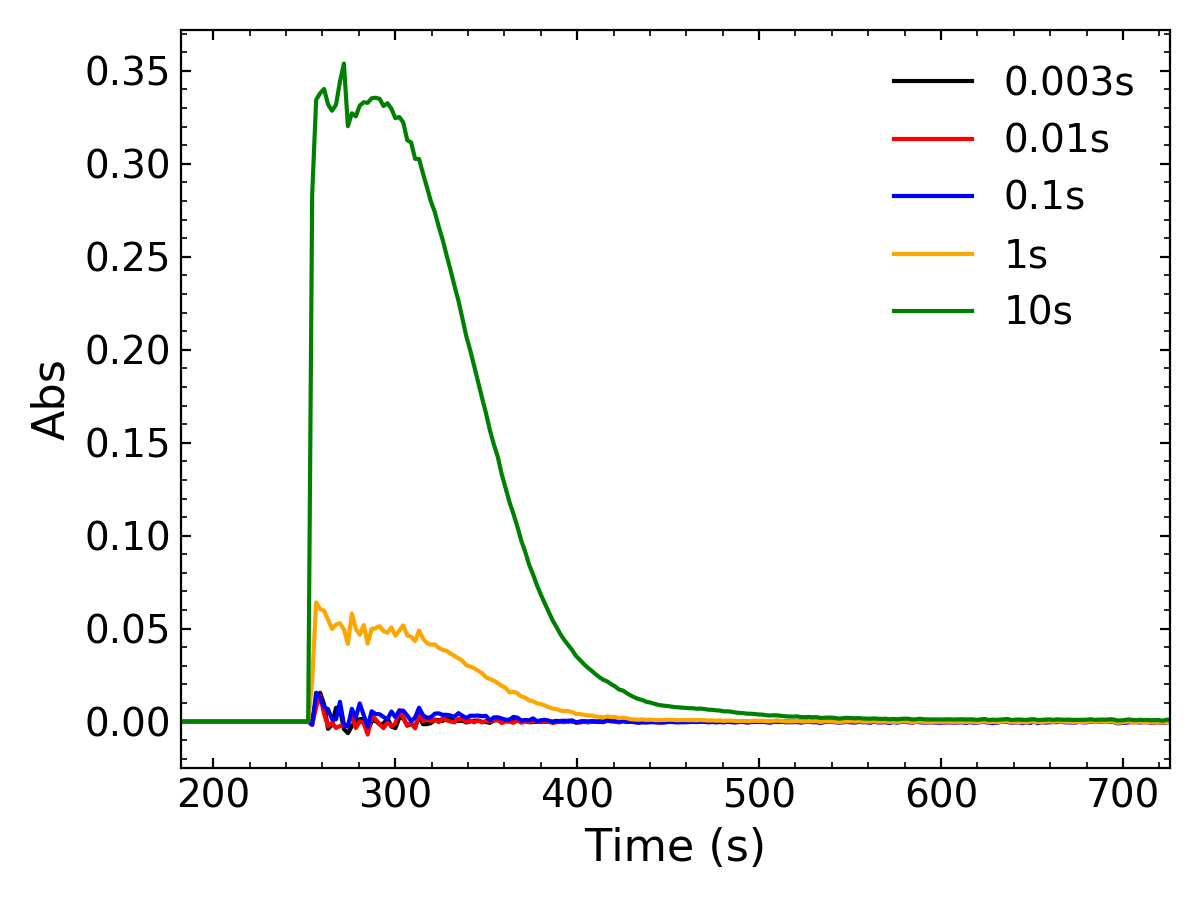

In [15]:
df = pandas.DataFrame(
    columns=['csvfile', 'legend', 'shift', 'scale', 'color', 'timepoint'],
    data=[
        ['average-sample-10s-ave.csv', '0.003s', 0, 1, 'black', 0.003],
        ['average-sample-10s-ave.csv', '0.01s', 0, 1, 'red', 0.01],
        ['average-sample-10s-ave.csv', '0.1s', 0, 1, 'blue', 0.1],
        ['average-sample-10s-ave.csv', '1s', 0, 1, 'orange', 1],
        ['average-sample-10s-ave.csv', '10s', 0, 1, 'green', 10],
    ]
)

base = pandas.DataFrame(
    columns=['csvfile', 'timepoint'],
    data=[
        ['average-sample-10s-ave.csv', 0.002],
    ]
)

# plot_from_df(df, valuetype='timepoint') # no subtraction
plot_from_df(df, valuetype='timepoint', base=base) # subtract spectra at certain timepoint

## plot with variables (lower level API)

<IPython.core.display.Javascript object>


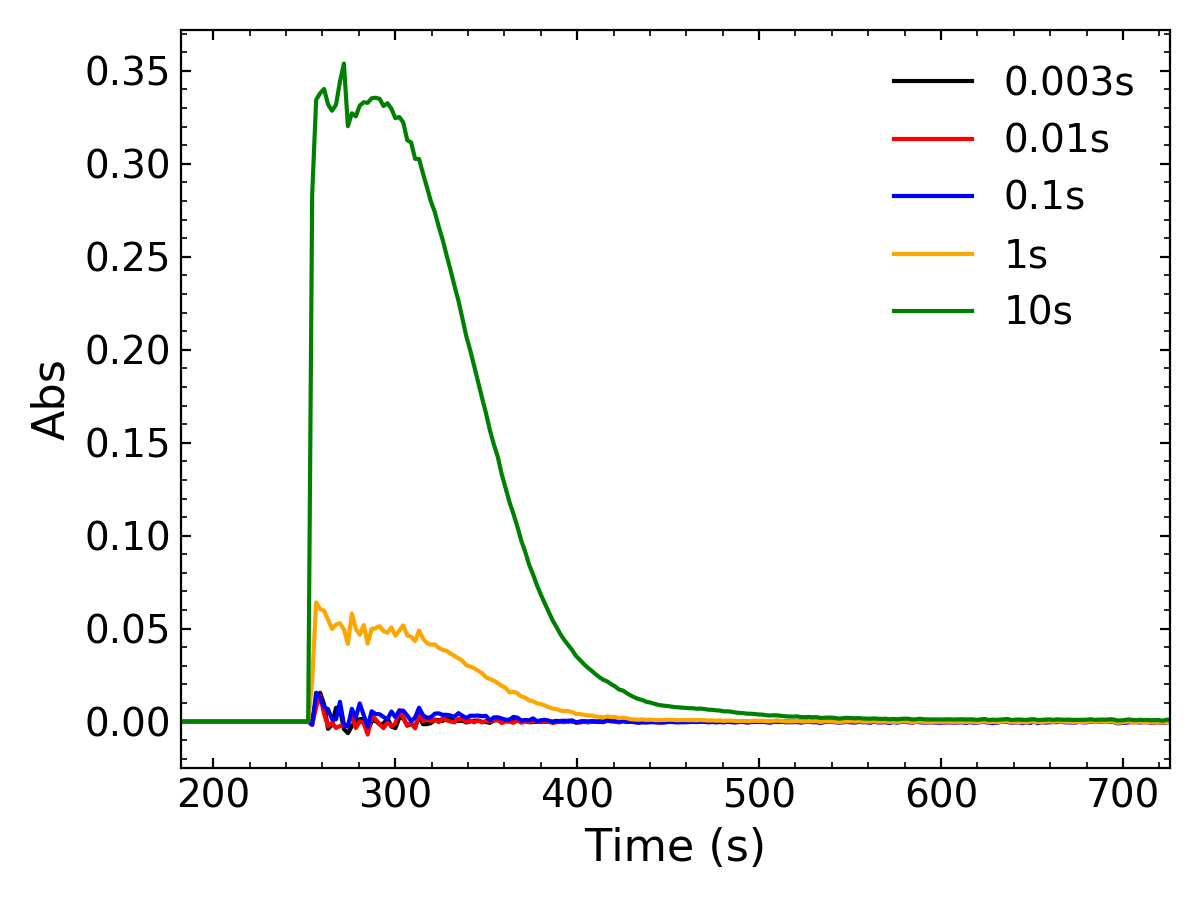

In [16]:
rcParams['figure.figsize'] = [6, 4.5]
fig = plt.figure()
axis = fig.gca()

csvfiles = [
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
]

dfs = list(map(load_data, csvfiles))
df_base = dfs[0].iloc[1,:]
dfs = [df - df_base for df in dfs]

timepoints = [
    [0.003],
    [0.01],
    [0.1],
    [1],
    [10]
]

legends = [
    ['0.003s'],
    ['0.01s'],
    ['0.1s'],
    ['1s'],
    ['10s']
]

shifts = [
    [0],
    [0],
    [0],
    [0],
    [0]
]

scales = [
    [1],
    [1],
    [1],
    [1],
    [1],
]

colors = [
    ['black'],
    ['red'],
    ['blue'],
    ['orange'],
    ['green']
]

sfData = SFData(
    axis=axis,
    dfs=dfs,
    colors=colors,
    legends=legends,
    scales=scales,
    shifts=shifts,
    xlabel='Time (s)',
    ylabel='Abs',
)

sfData.plot_selected_spectra(timepoints)
# display(widgets.HBox([sfData.plot_scan_timepoint_button()]))
sfData.plot_interactive_buttons_for_spectra()

# plot kinetic curves with more options

## plot with table

<IPython.core.display.Javascript object>


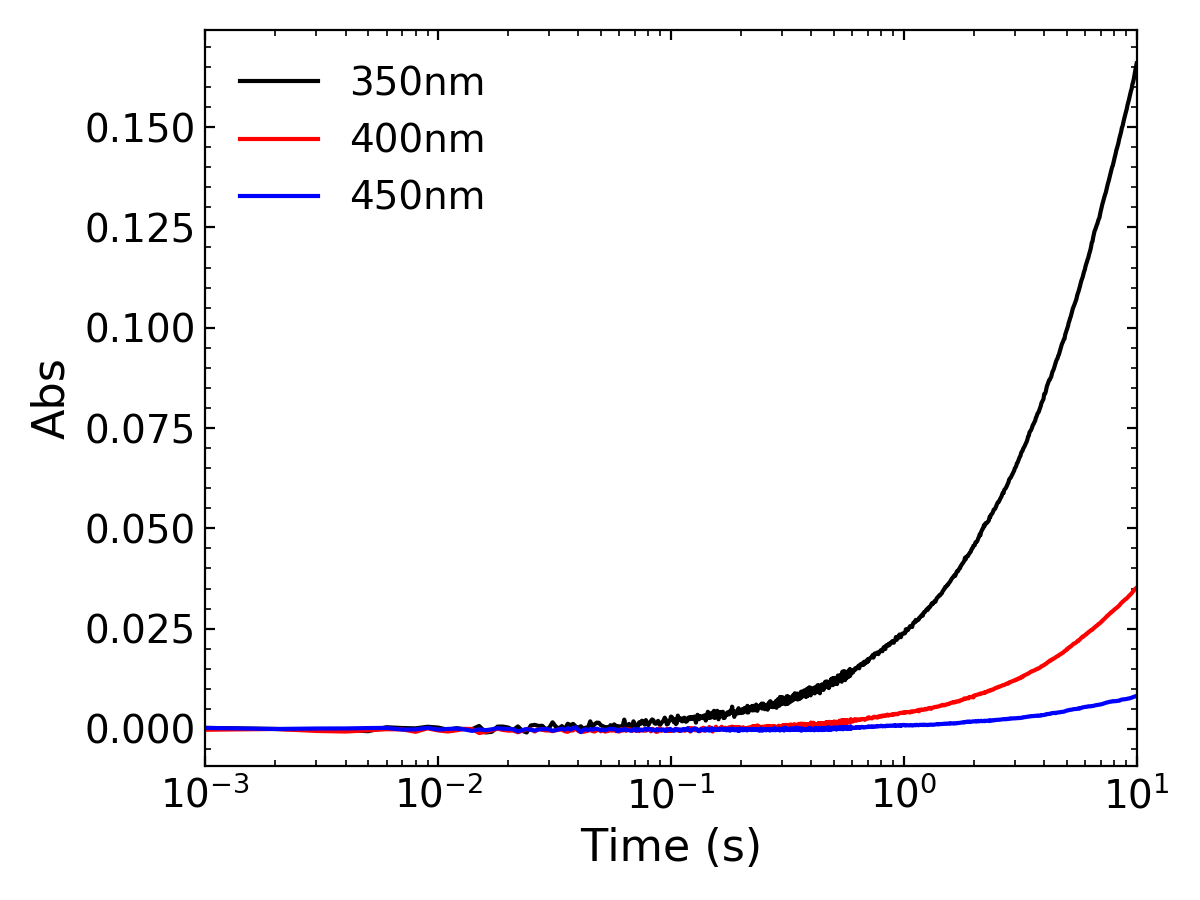

interactive(children=(ToggleButton(value=True, description='LogX', icon='check', tooltip='Description'), Outpu…

In [17]:
df = pandas.DataFrame(
    columns=['csvfile', 'legend', 'shift', 'scale', 'color', 'wavelength'],
    data=[
        ['average-sample-10s-ave.csv', '350nm', 0, 1, 'black', 350],
        ['average-sample-10s-ave.csv', '400nm', 0, 1, 'red', 400],
        ['average-sample-10s-ave.csv', '450nm', 0, 1, 'blue', 450],
    ]
)

base = pandas.DataFrame(
    columns=['csvfile', 'timepoint'],
    data=[
        ['average-sample-10s-ave.csv', 0.002],
    ]
)

# plot_from_df(df, valuetype='wavelength')   
plot_from_df(df, valuetype='wavelength', base=base)

## plot with variables (lower level API)

<IPython.core.display.Javascript object>


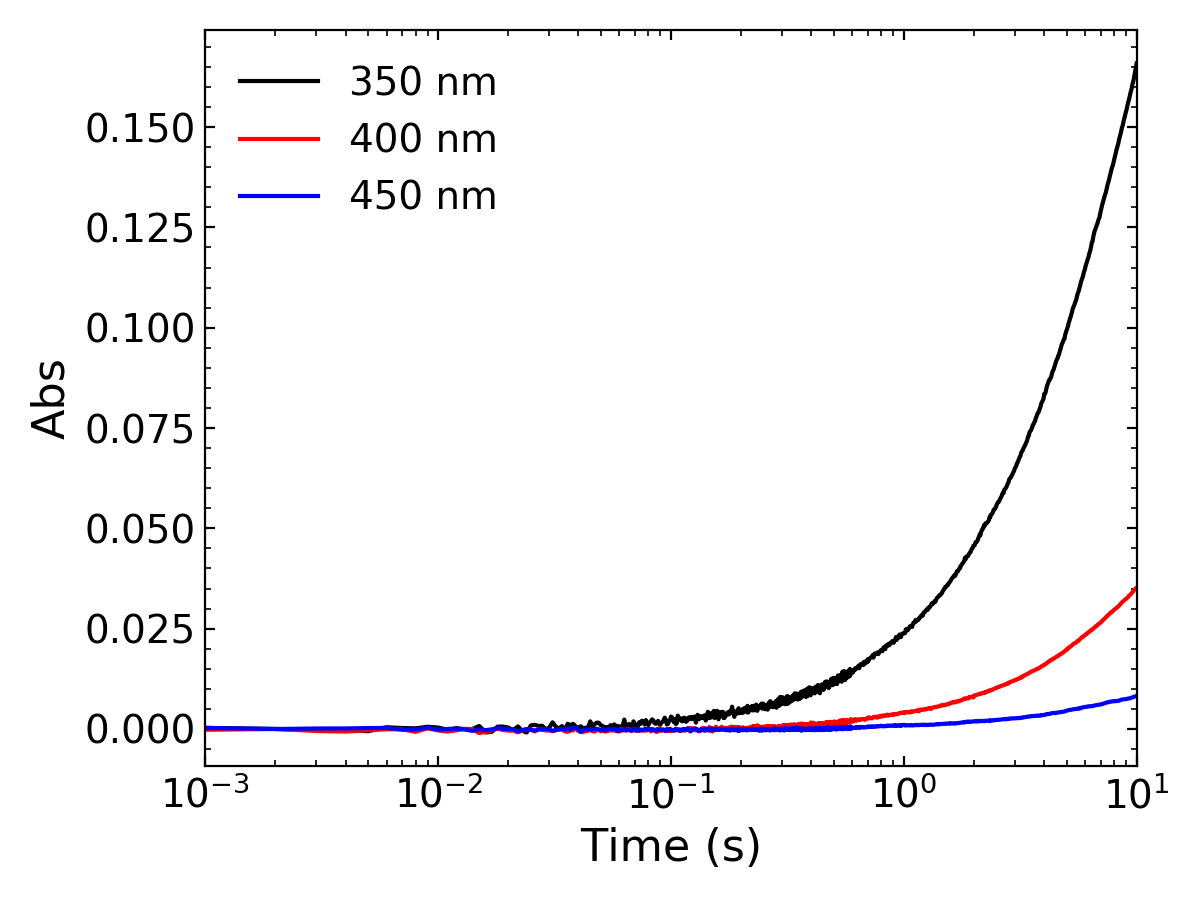

interactive(children=(ToggleButton(value=True, description='LogX', icon='check', tooltip='Description'), Outpu…

In [18]:
rcParams['figure.figsize'] = [6, 4.5]
fig = plt.figure()
axis = fig.gca()

csvfiles = [
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
]

dfs = list(map(load_data, csvfiles))

df_base = dfs[0].iloc[1,:]
dfs = [df - df_base for df in dfs]

wavelengths = [
    [350],
    [400],
    [450],
]

legends = [
    ['350 nm'],
    ['400 nm'],
    ['450 nm'],
]

shifts = [
    [0],
    [0],
    [0],
]

scales = [
    [1],
    [1],
    [1],
]

colors = [
    ['black'],
    ['red'],
    ['blue'],
]

sfData = SFData(
    axis=axis,
    dfs=dfs,
    colors=colors,
    legends=legends,
    scales=scales,
    shifts=shifts,
    xlabel='Time (s)',
    ylabel='Abs',
)

sfData.plot_selected_kinetics(wavelengths)
display(sfData.add_logx_button())
# display(widgets.HBoxsfDataData.add_logx_button(), sfData.plot_scan_wavelength_button()]))
sfData.plot_interactive_buttons_for_kinetics()

# overview - kinetic curve and full spectra
<span style="color:red">Warning: this section is slow</span>

<IPython.core.display.Javascript object>


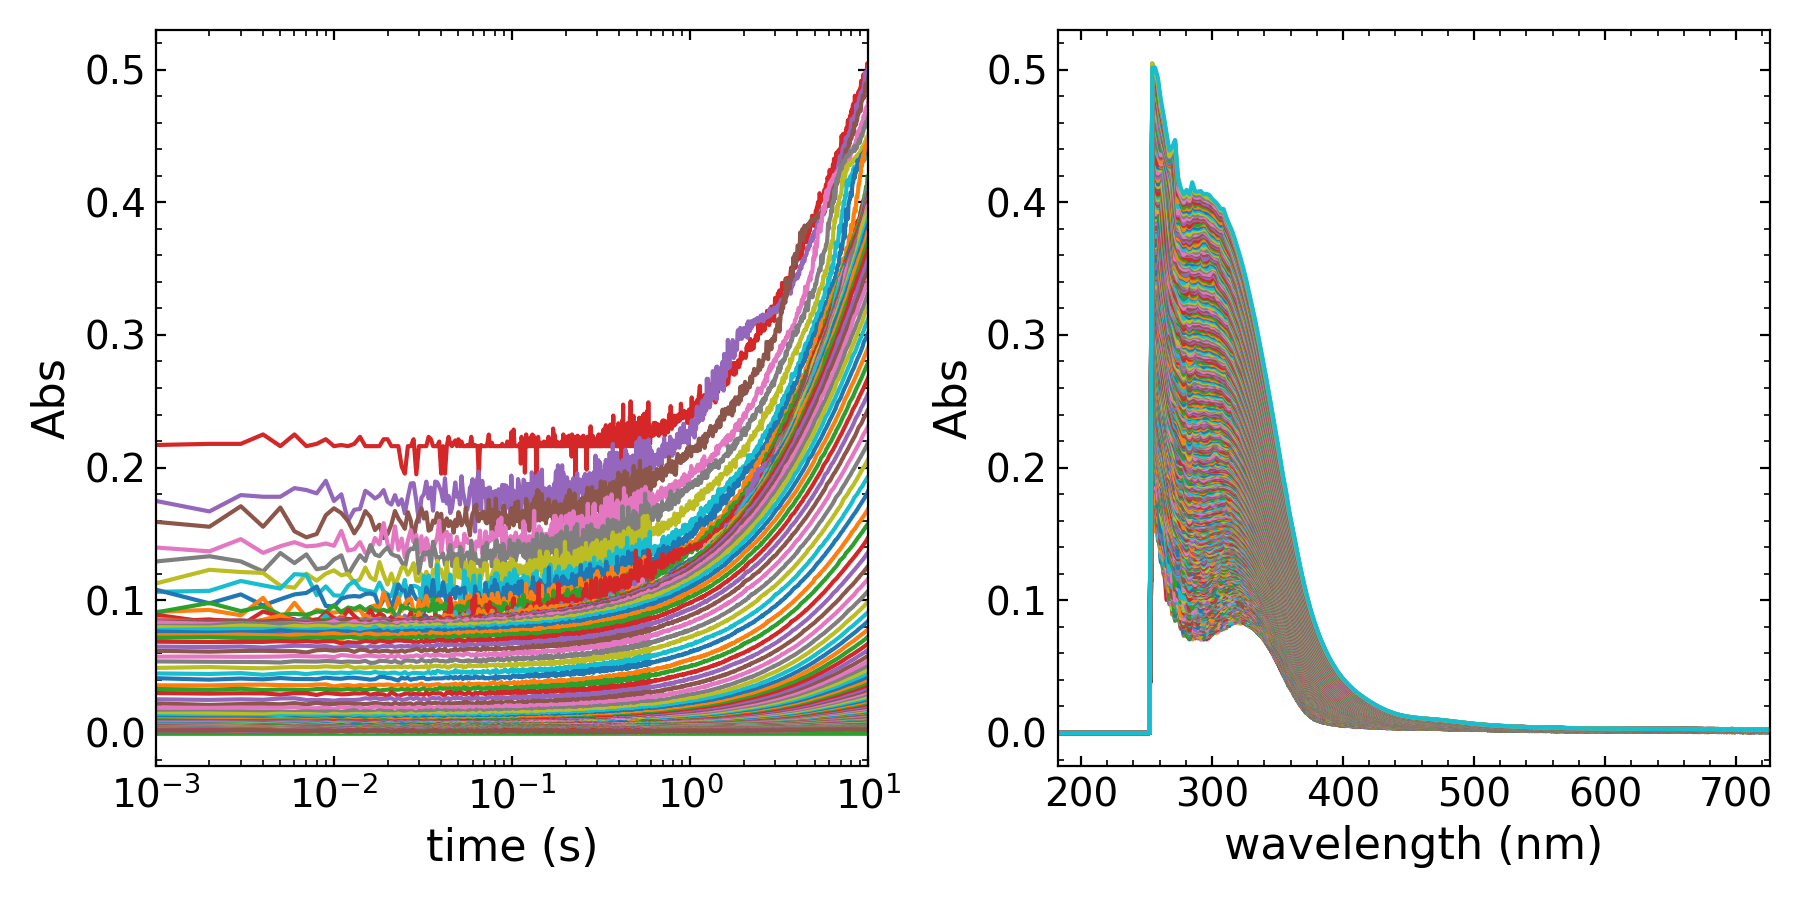

In [19]:
rcParams['figure.figsize'] = [9, 4.5]
csvfile = 'average-sample-10s-ave.csv'
df = load_data(csvfile)
(row, col) = (1, 2)
fig, axs = plt.subplots(row, col, sharex=False, sharey=False)
axis1 = axs[0]  # first axis
axis2 = axs[1]  # second axis

plot_all_kinetic(df, axis1)
plot_all_spectra(df, axis2)

# overview - difference spectra
<span style="color:red">Warning: this section is slow</span>

<IPython.core.display.Javascript object>


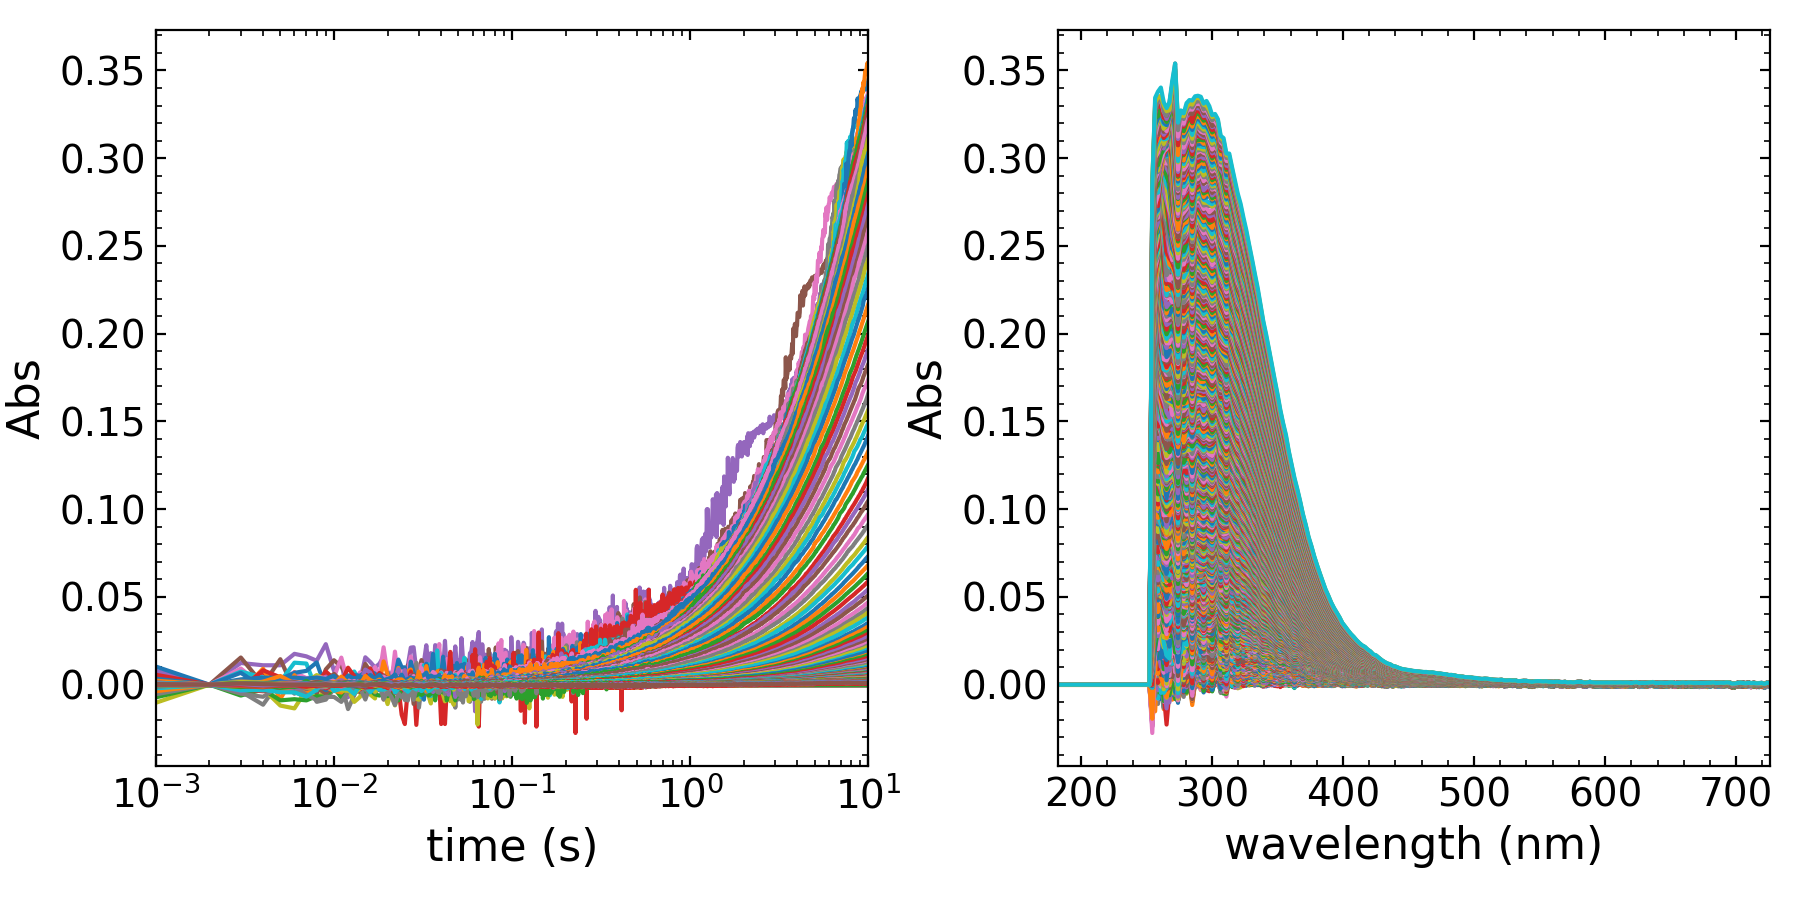

In [20]:
rcParams['figure.figsize'] = [9, 4.5]
df = load_data(csvfile)
baseCurve = df.iloc[1,:] # select the second time point as baseline
diffDf = df - baseCurve
df1 = df - baseCurve
(row, col) = (1, 2)
fig, axs = plt.subplots(row, col, sharex=False, sharey=False)
axis1 = axs[0]  # first axis
axis2 = axs[1]  # second axis

plot_all_kinetic(df1, axis1)
plot_all_spectra(df1, axis2)

# export kintek input files

In [21]:
csvfile = 'kintek-sample-10s.csv'
wavelengths = [429]
kintekFileName = 'kintek-sample-10s-429nm.txt'
export_kintek(csvfile, wavelengths, kintekFileName)

kintek input file saved as kintek-sample-10s-429nm.txt


# plot original kinetic and kintek simulation

<IPython.core.display.Javascript object>


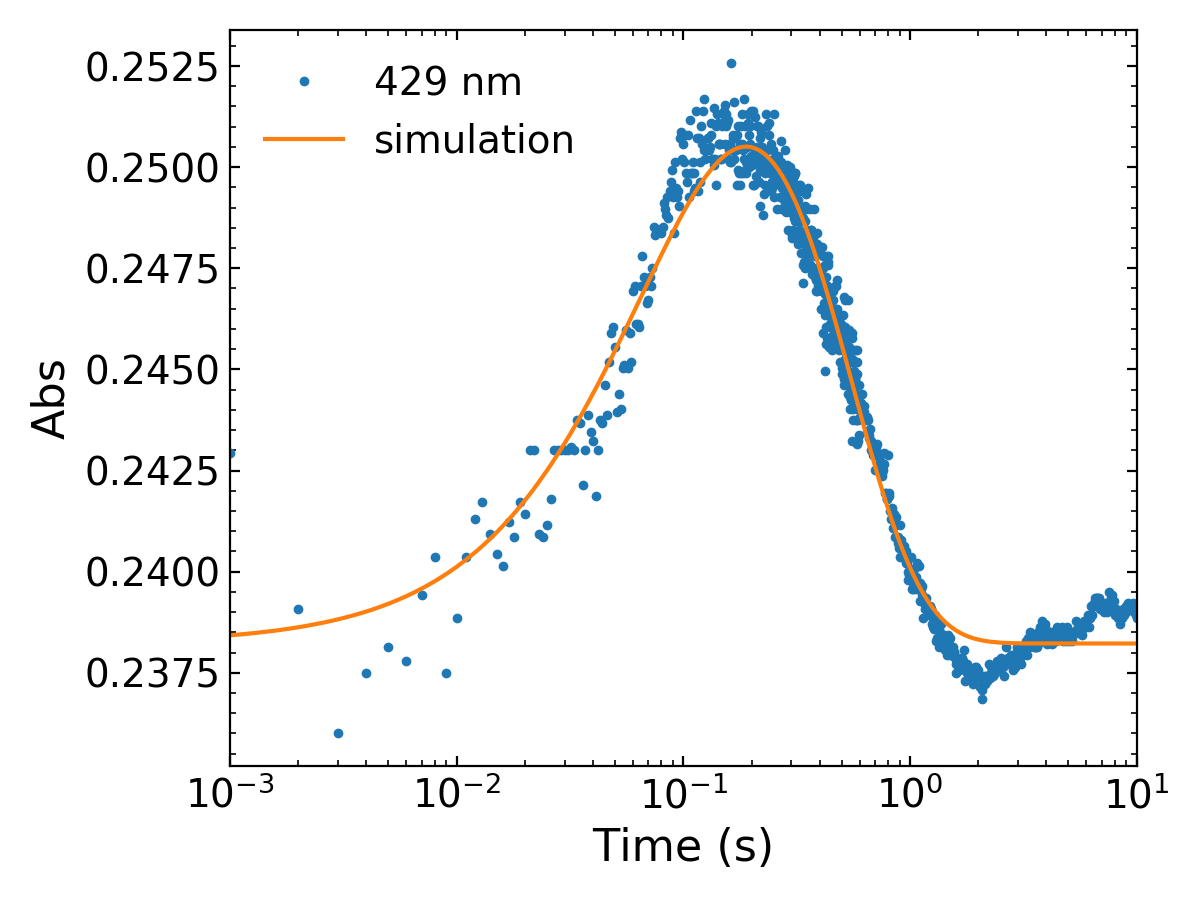

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:444: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(self.xlim)


In [22]:
rcParams['figure.figsize'] = [6, 4.5]
rcParams.update({'xtick.labelsize': 14})
rcParams.update({'ytick.labelsize': 14})
rcParams.update({'axes.labelsize':16})
rcParams.update({'legend.frameon': False})
rcParams.update({'legend.fontsize': 14})

kintekFileName = 'kintek-sample-10s-429nm.txt'
simFileName = 'kintek-sample-10s-429nm-sim.txt'
dfExp = pandas.read_csv(
    kintekFileName,  # file name
    skiprows=0,  # leading rows that should not be read-in
    delimiter='\t',
    header=0,
    index_col=0,
#     nrows=1000,
    engine='python'
)
dfSim = pandas.read_csv(
    simFileName,  # file name
    skiprows=0,  # leading rows that should not be read-in
    delimiter='\t',
    header=0,
    index_col=0,
#     nrows=1000,
    engine='python'
).dropna(axis='columns', how='any')

fig = plt.figure()
axis = fig.gca()
dfExp.plot.line(
    marker='.',
    markersize=5,
    linewidth=0,
    ax=axis,
    logx=True,
    xlim=(0,10),
    legend=None
)
dfSim.plot.line(
    ax=axis,
    logx=True,
    xlim=(0,10),
    legend=None
)

axis.set_xlabel('Time (s)')
axis.set_ylabel('Abs')
handles, labels = axis.get_legend_handles_labels()
labels = ['429 nm', 'simulation']
_ = axis.legend(handles, labels).set_draggable(True)